# Experiments in Interpolation

A notebook for developing an interpolation function for the `beammaps` class

In [2]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'

## Beammap module copied from beammap.py

(with my edits)

In [3]:
#  _                                                             
# | |                                                            
# | |__   ___  __ _ _ __ ___  _ __ ___   __ _ _ __   _ __  _   _ 
# | '_ \ / _ \/ _` | '_ ` _ \| '_ ` _ \ / _` | '_ \ | '_ \| | | |
# | |_) |  __/ (_| | | | | | | | | | | | (_| | |_) || |_) | |_| |
# |_.__/ \___|\__,_|_| |_| |_|_| |_| |_|\__,_| .__(_) .__/ \__, |
#                                            | |    | |     __/ |
#                                            |_|    |_|    |___/ 
        
## 20230411_WT: introducing class and adding it to the package....

## Class for position-space sorting/averaging of beammap flight data, from time domain data:

from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
import hdf5plugin
import os
import glob
from matplotlib import colors
import pandas
import csv
import datetime
import pytz
import bisect
import pygeodesy
import yaml
from scipy.signal import square
from scipy.stats import pearsonr
import glob
import pickle
from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

## Class for position-space sorting/averaging of beammap flight data, from time domain data:
#defines coordinate vector from xmax to xmin spaced roughly by xres:
def cedges(args):
    cmin,cmax,cres=args
    return np.linspace(cmin,cmax,int((cmax-cmin)/cres)+1)

class Beammap:
    def __init__(self,concatlist=[],gfitlist=[],Xargs=[-100,100,5],Yargs=[-100,100,5],\
                 Fargs=[0,1024,1],f_index=900,\
                 operation='coadd',inputstyle='pickle',normalization='none',vplot=True,\
                 pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/',\
                 gfit_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/',\
                 flightmasterpath='../analysis/GBO_flights_forscripts.yaml'):
        ## enable format of input to be load from 'pickle' filestring or bin/map using concat 'class':        
        self.concat_list=concatlist
        self.gfit_list=gfitlist
        nchanslist=np.zeros(len(concatlist))
        if inputstyle=='pickle':
            for h,cstring in enumerate(concatlist):
                ## using the with loop structure, the pickle file is closed after ccc is loaded:
                with open(pickle_directory+cstring, "rb") as f:
                    CONCATCLASS=pickle.load(f)
                nchanslist[h]=CONCATCLASS.n_channels
                self.FLYNUM=cstring.split('FLY')[1].split('_')[0]
        elif inputstyle=='class':
            CONCATCLASS=concatlist[0]
            for h,cstring in enumerate(concatlist):
                nchanslist[h]=cstring.n_channels
                self.FLYNUM=cstring.FLYTAG.split('FLY')[1].split('.')[0]
        
        ## determine which channel is co-pol, for frequency dependent centroid corrections:
        with open(flightmasterpath, 'r') as flightmaster:
            doccs = yaml.safe_load(flightmaster)
            for j,fstr in enumerate(doccs['flight_info']['flights']):
                if self.FLYNUM in fstr:
                    self.copoldir=doccs['flight_info']['pols'][j]

        #get variables that should be kept along from the first concat class:         
        self.name=CONCATCLASS.name
        self.Data_Directory=CONCATCLASS.Data_Directory
        self.Gain_Directory=CONCATCLASS.Gain_Directory
        self.filenames=CONCATCLASS.filenames
        self.gainfile=CONCATCLASS.gainfile
        self.Drone_Directory=CONCATCLASS.Drone_Directory
        self.FLYTAG=CONCATCLASS.FLYTAG
        self.n_dishes=CONCATCLASS.n_dishes
        self.n_channels=int(np.nanmin(nchanslist))
        self.n_concats=len(concatlist)
        self.chmap=CONCATCLASS.chmap
        self.automap=CONCATCLASS.automap
        self.crossmap=CONCATCLASS.crossmap
        self.origin=CONCATCLASS.origin
        #self.prime_origin=CONCATCLASS.prime_origin ## omit, it breaks the pickle
        self.dish_keystrings=CONCATCLASS.dish_keystrings
        self.dish_coords=CONCATCLASS.dish_coords
        self.dish_pointings=CONCATCLASS.dish_pointings
        self.dish_polarizations=CONCATCLASS.dish_polarizations
        fmin,fmax,fstep=Fargs
        self.faxis=np.arange(fmin,fmax,fstep)
        self.freq=CONCATCLASS.freq[self.faxis]
        find=np.where(self.faxis==f_index)[0][0]
        
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        self.operation=operation
        xedges,yedges=(cedges(Xargs),cedges(Yargs))
        xedgesgrid,yedgesgrid=np.meshgrid(xedges,yedges)
        xcenters,ycenters=(cedges(Xargs)[:-1]+Xargs[2]/2.0,cedges(Yargs)[:-1]+Yargs[2]/2.0)
        xcentersgrid,ycentersgrid=np.meshgrid(xcenters,ycenters)
        
        #need to extend this to dimensionality of channels in concatclass.V
        self.x_edges=np.zeros(xedges.shape+(self.n_channels,))
        self.y_edges=np.zeros(yedges.shape+(self.n_channels,))
        self.x_edges_grid=np.zeros((xedgesgrid.shape+(self.n_channels,)))
        self.y_edges_grid=np.zeros((yedgesgrid.shape+(self.n_channels,)))
        self.x_centers=np.zeros(xcenters.shape+(self.n_channels,))
        self.y_centers=np.zeros(ycenters.shape+(self.n_channels,))
        self.x_centers_grid=np.zeros((xcentersgrid.shape+(self.n_channels,)))
        self.y_centers_grid=np.zeros((ycentersgrid.shape+(self.n_channels,)))
        for i in range(self.n_channels):
            if 'D3A' in CONCATCLASS.name:
                xoff=CONCATCLASS.dish_coords[i][0]
                yoff=CONCATCLASS.dish_coords[i][1]
            elif 'GBO' in CONCATCLASS.name:
                xoff=CONCATCLASS.dish_coords[i][0]
                yoff=CONCATCLASS.dish_coords[i][1]
            self.x_edges[:,i]=xedges
            self.x_centers[:,i]=xcenters
            self.y_edges[:,i]=yedges
            self.y_centers[:,i]=ycenters
            self.x_centers_grid[:,:,i]=xcentersgrid
            self.y_centers_grid[:,:,i]=ycentersgrid
            self.x_edges_grid[:,:,i]=xedgesgrid
            self.y_edges_grid[:,:,i]=yedgesgrid
            
        ## now need frequency dependent offset terms in shape (freq, channel, concat) to mimic V
        self.x_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))
        self.y_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))
        
        ## create arrays for V mean, V std, and histo: shape is (gridx, gridy, freq, chans, concatlist)
        self.V_LC_mean=np.NAN*np.ones((len(self.x_centers[:,0]),len(self.y_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.V_LC_std=np.NAN*np.ones((len(self.x_centers[:,0]),len(self.y_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.histogram_LC=np.NAN*np.ones((len(self.x_centers[:,0]),len(self.y_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        
        ## loop through the concat classes (h,ccc=concatclass) and extract hist/V parameters:
        if vplot==True:
            fig0,axes0=subplots(nrows=2,ncols=4,figsize=(40,20))
            
        print("start of big ass loop is: {}".format(datetime.datetime.now()))

        for h,cstring in enumerate(concatlist):
            ## create automatic verification plot axes:
            if vplot==True:
                fig,axes=subplots(nrows=2,ncols=4,figsize=(40,20))
            ## using the with loop structure, the pickle file is closed after ccc is loaded:
            if inputstyle=='pickle':
                with open(pickle_directory+cstring, "rb") as f:
                    ccc=pickle.load(f)   
            elif inputstyle=='class':
                ccc=cstring
            t_cut=ccc.inds_on
            if normalization=='none':          
                if vplot==True:
                    im1x=axes[0][0].scatter(ccc.drone_xyz_per_dish_interp[0,t_cut,0],ccc.drone_xyz_per_dish_interp[0,t_cut,1],c=ccc.V_bgsub[t_cut,f_index,0],cmap=cm.gnuplot2,norm=LogNorm())
                    im1y=axes[1][0].scatter(ccc.drone_xyz_per_dish_interp[1,t_cut,0],ccc.drone_xyz_per_dish_interp[1,t_cut,1],c=ccc.V_bgsub[t_cut,f_index,1],cmap=cm.gnuplot2,norm=LogNorm())    
                    im1x0=axes0[0][0].scatter(ccc.drone_xyz_per_dish_interp[0,t_cut,0],ccc.drone_xyz_per_dish_interp[0,t_cut,1],c=ccc.V_bgsub[t_cut,f_index,0],cmap=cm.gnuplot2,norm=LogNorm())
                    im1y0=axes0[1][0].scatter(ccc.drone_xyz_per_dish_interp[1,t_cut,0],ccc.drone_xyz_per_dish_interp[1,t_cut,1],c=ccc.V_bgsub[t_cut,f_index,1],cmap=cm.gnuplot2,norm=LogNorm())    
                else:
                    pass
            elif normalization=='Gauss':
                if len(gfitlist)==0:
                    print('ERROR: --> The normalization cannot be applied because the gfitlist is empty')
                elif len(gfitlist)!=len(concatlist):
                    print('ERROR: --> The length of the gfitlist is not equal to the length of the concatlist')
                elif len(gfitlist)==len(concatlist):
                    ## make sure the normalization is being appropriately applied to the correct file:
                    if concatlist[h].split('_')[0]==gfitlist[h].split('_')[0]:
                        with np.load(gfit_directory+gfitlist[h]) as gff:
                            g_norm=gff['G_popt'][:,:,0]
                            for i in range(self.n_channels):
                                if self.copoldir in 'E':
                                    COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][0]
                                    self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                                    self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset
                                elif self.copoldir in 'N':
                                    COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][1]
                                    self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                                    self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset
                                else:
                                    print('your loop sucks idiot')                                 
                            if vplot==True:
                                im1x=axes[0][0].scatter(ccc.drone_xyz_per_dish_interp[0,t_cut,0]+self.x_offsets[find,i,h],ccc.drone_xyz_per_dish_interp[0,t_cut,1]+self.y_offsets[find,i,h],c=(1.0/g_norm[0,f_index])*ccc.V_bgsub[t_cut,f_index,0],cmap=cm.gnuplot2,norm=LogNorm())
                                im1y=axes[1][0].scatter(ccc.drone_xyz_per_dish_interp[1,t_cut,0]+self.x_offsets[find,i,h],ccc.drone_xyz_per_dish_interp[1,t_cut,1]+self.y_offsets[find,i,h],c=(1.0/g_norm[1,f_index])*ccc.V_bgsub[t_cut,f_index,1],cmap=cm.gnuplot2,norm=LogNorm())
                                im1x0=axes0[0][0].scatter(ccc.drone_xyz_per_dish_interp[0,t_cut,0]+self.x_offsets[find,i,h],ccc.drone_xyz_per_dish_interp[0,t_cut,1]+self.y_offsets[find,i,h],c=(1.0/g_norm[0,f_index])*ccc.V_bgsub[t_cut,f_index,0],cmap=cm.gnuplot2,norm=LogNorm())
                                im1y0=axes0[1][0].scatter(ccc.drone_xyz_per_dish_interp[1,t_cut,0]+self.x_offsets[find,i,h],ccc.drone_xyz_per_dish_interp[1,t_cut,1]+self.y_offsets[find,i,h],c=(1.0/g_norm[1,f_index])*ccc.V_bgsub[t_cut,f_index,1],cmap=cm.gnuplot2,norm=LogNorm())
                            else:
                                pass
                            
                            
            ## ATTEMPT TO BYPASS chan,freq LOOPS:
            ## create centroid-corrected per channel and frequency drone coordinate maps on a per-concat basis:
            tmpcoords=np.repeat(ccc.drone_xyz_per_dish_interp[:,:,:,np.newaxis],len(self.freq),axis=3)
            shiftvec=np.array((self.x_offsets[:,:,h],self.y_offsets[:,:,h],np.zeros(self.x_offsets[:,:,h].shape)))
            tmpshifts=np.repeat(np.swapaxes(np.swapaxes(shiftvec,0,2),1,2)[:,np.newaxis,:,:],len(ccc.t),axis=1)
            fccoords=(tmpcoords-tmpshifts)[:,ccc.inds_on]
            if normalization=='none':
                Vvals=ccc.V_bgsub[ccc.inds_on,:,:]
            elif normalization=='Gauss':
                Vvals=(np.repeat(np.swapaxes(g_norm[:,fmin:fmax:fstep],0,1)[np.newaxis,:,:],len(ccc.inds_on),axis=0)**-1)*ccc.V_bgsub[ccc.inds_on,fmin:fmax:fstep,:]           
            ## loop through channels (i,chan) to find indices of nonzero cells in histogram
            for i,chan in enumerate(range(self.n_channels)):
                for j,fr in enumerate(self.faxis):
                    print('Concat:{}/{}, Channel:{}/{}, Frequency:{}/{},           '.format(h+1,self.n_concats,i+1,self.n_channels,j+1,len(self.freq)),end='\r')
                    xf,yf=fccoords[i,:,0,j],fccoords[i,:,1,j]
                    valsf=Vvals[:,j,i]                        
                    #histo2d,xbins,ybins=np.histogram2d(x,y,bins=[self.x_edges[:,i],self.y_edges[:,i]])
                    self.histogram_LC[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',bins=[self.x_edges[:,i],self.y_edges[:,i]]).statistic
                    self.V_LC_mean[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='mean',bins=[self.x_edges[:,i],self.y_edges[:,i]]).statistic
                    self.V_LC_std[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='std',bins=[self.x_edges[:,i],self.y_edges[:,i]]).statistic
                              
#             ## THIS LOOP IS SLOW, MABE WE FIND A WAY TO DO IT IN ARRAY SPACE: SAVE THIS DONT DELETE YET
#             ## loop through channels (i,chan) to find indices of nonzero cells in histogram
#             for i,chan in enumerate(range(self.n_channels)):
#                 ## now must loop through frequency space to accomodate freq-dependent centroid removal:
#                 for j,fr in enumerate(self.faxis):
#                     print('Concat:{}/{}, Channel:{}/{}, Frequency:{}/{},           '.format(h+1,self.n_concats,i+1,self.n_channels,j+1,len(self.freq)),end='\r')
#                     x,y=[ccc.drone_xyz_per_dish_interp[i,:,0]+self.x_offsets[j,i,h],ccc.drone_xyz_per_dish_interp[i,:,1]+self.y_offsets[j,i,h]]
#                     histo2d,xbins,ybins=np.histogram2d(x,y,bins=[self.x_edges[:,i],self.y_edges[:,i]])
#                     self.histogram_LC[:,:,j,i,h]=histo2d
#                     xnz,ynz=np.where(histo2d!=0)
#                     ## loop over the bins [m] where the histogram is nonzero to populate the bins of the V_arrays:
#                     for m in range(len(xnz)):
#                         k,l=[xnz[m],ynz[m]]
#                         ## find times [tacc] where the drones coordinates x,y are with in the bin m x,y values:
#                         xacc=np.intersect1d(np.where(self.x_edges[k,i]<=x),np.where(self.x_edges[k+1,i]>x))
#                         yacc=np.intersect1d(np.where(self.y_edges[l,i]<=y),np.where(self.y_edges[l+1,i]>y))
#                         tacc0=np.intersect1d(xacc,yacc)
#                         tacc=np.intersect1d(tacc0,ccc.inds_on)
#                         if normalization=='none':
#                             ## Populate the V arrays with the appropriate values:
#                             self.V_LC_mean[k,l,j,i,h]=np.nanmean(ccc.V_bgsub[tacc,fr,i],axis=0)
#                             self.V_LC_std[k,l,j,i,h]=np.nanstd(ccc.V_bgsub[tacc,fr,i],axis=0)       
#                         elif normalization=='Gauss':
#                             ## Apply normalization, if possible from gauss fit params:
#                             self.V_LC_mean[k,l,j,i,h]=np.nanmean((1.0/g_norm[i,j])*ccc.V_bgsub[tacc,fr,i],axis=0)
#                             self.V_LC_std[k,l,j,i,h]=np.nanstd((1.0/g_norm[i,j])*ccc.V_bgsub[tacc,fr,i],axis=0)
            if vplot==True:
                for i in range(2):
                    ax1,ax2,ax3,ax4=axes[i]
                    im2=ax2.pcolormesh(self.x_edges_grid[:,:,i],self.y_edges_grid[:,:,i],self.histogram_LC[:,:,find,i,h].T,cmap=cm.gnuplot2)
                    im2.set_clim(0,30)
                    im3=ax3.pcolormesh(self.x_edges_grid[:,:,i],self.y_edges_grid[:,:,i],self.V_LC_mean[:,:,find,i,h].T,cmap=cm.gnuplot2,norm=LogNorm())
                    im4=ax4.pcolormesh(self.x_edges_grid[:,:,i],self.y_edges_grid[:,:,i],self.V_LC_std[:,:,find,i,h].T,cmap=cm.gnuplot2,norm=LogNorm())
                    images=[[im1x,im1y][i],im2,im3,im4]
                    titles=['Unbinned Beammaps ({} CH{} {:.2f} MHz)'.format(self.concat_list[h].split('_')[0],i,self.freq[find]),\
                            'Histogram ({} CH{} {:.2f} MHz)'.format(self.concat_list[h].split('_')[0],i,self.freq[find]),\
                            r'Coadded $\bar{x}$'+' Map ({} CH{} {:.2f} MHz)'.format(self.concat_list[h].split('_')[0],i,self.freq[find]),\
                            'Coadded $\sigma$ Map ({} CH{} {:.2f} MHz)'.format(self.concat_list[h].split('_')[0],i,self.freq[find])]
                    cbarlabels=['Power [$ADU^2$]','Counts','Power [$ADU^2$]','Power [$ADU^2$]']
                    for j,ax in enumerate([ax1,ax2,ax3,ax4]):
                        ax.set_title(titles[j])
                        ax.set_facecolor('k')
                        ax.set_xlabel('$x,[m]$')
                        ax.set_ylabel('$y, [m]$')
                        divider=make_axes_locatable(ax)
                        cax=divider.append_axes("right", size="3%", pad=0.05)
                        cbar=fig.colorbar(images[j],cax=cax)
                        cbar.set_label(cbarlabels[j])
                tight_layout()
                
        print("end of bigass loop is: {}".format(datetime.datetime.now()))

        if operation=='coadd':
            self.V_LC_operation=np.NAN*np.ones(self.V_LC_mean[:,:,:,:,0].shape)
            self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)
        elif operation=='difference':
            if len(concatlist)==2:
                self.V_LC_operation=np.NAN*np.ones(self.V_LC_mean[:,:,:,:,0].shape)
                self.V_LC_operation=np.nansum(np.array([self.V_LC_mean[:,:,:,:,0],-1*self.V_LC_mean[:,:,:,:,1]]),axis=0)
            else:
                print("--> V_LC_operation can only be instantiated if the length of concatlist is 2")
        if vplot==True:
            for i in range(2):
                ax1,ax2,ax3,ax4=axes0[i]
                im2=ax2.pcolormesh(self.x_edges_grid[:,:,i],self.y_edges_grid[:,:,i],np.nansum(self.histogram_LC[:,:,find,i,:],axis=2).T,cmap=cm.gnuplot2)
                im2.set_clim(0,300)
                im3=ax3.pcolormesh(self.x_edges_grid[:,:,i],self.y_edges_grid[:,:,i],self.V_LC_operation[:,:,find,i].T,cmap=cm.gnuplot2,norm=LogNorm())
                im4=ax4.pcolormesh(self.x_edges_grid[:,:,i],self.y_edges_grid[:,:,i],np.nanmean(self.V_LC_std[:,:,find,i,:],axis=2).T,cmap=cm.gnuplot2,norm=LogNorm())
                images=[[im1x0,im1y0][i],im2,im3,im4]
                titles=['Unbinned Beammaps ({} CH{} {:.2f} MHz)'.format(self.name,i,self.freq[find]),\
                        'Histogram ({} CH{} {:.2f} MHz)'.format(self.name,i,self.freq[find]),\
                        r'Coadded $\bar{x}$'+' Map ({} CH{} {:.2f} MHz)'.format(self.name,i,self.freq[find]),\
                        'Coadded $\sigma$ Map ({} CH{} {:.2f} MHz)'.format(self.name,i,self.freq[find])]
                cbarlabels=['Power [$ADU^2$]','Counts','Power [$ADU^2$]','Power [$ADU^2$]']
                for j,ax in enumerate([ax1,ax2,ax3,ax4]):
                    ax.set_title(titles[j])
                    ax.set_facecolor('k')
                    ax.set_xlabel('$x,[m]$')
                    ax.set_ylabel('$y, [m]$')
                    divider=make_axes_locatable(ax)
                    cax=divider.append_axes("right", size="3%", pad=0.05)
                    cbar=fig.colorbar(images[j],cax=cax)
                    cbar.set_label(cbarlabels[j])
            tight_layout()

    def complex_interpolation(self, x_interp, y_interp, method='linear',variogram_model='spherical',outputs=False,Fargs=[0,0]):

            '''
            Interpolates a complex beam along a grid defined by 1-D vectors x-interp, y-interp.
            x_interp and y_interp: 1-D vectors that define a grid to which the beam is interpolated
            method: 'linear' for linear interpolation (faster) or 'krig' for Krig interpolation
            variogram_model: variogram model for krig interpolation. Options: 'linear', 'power', 'gaussian', 'spherical', 'exponential', 'hole-effect'
            outputs: if True, provides output plots for the indicated frequencies
            Fargs: provide a list [fmin,fmax] with the starting and ending frequency indices for which you want to see output plots
            '''

            # if there is only one concat class, interpolates the mean. if not, interpolates the coadded/subtracted beam
            if self.n_concats==1:
                new_shape = np.asarray(self.V_LC_mean.shape)[0:4]
                V_LC = np.reshape(self.V_LC_mean,new_shape)
            else:
                V_LC=self.V_LC_operation

            V_LC_real = V_LC.real
            V_LC_im = V_LC.imag

            # checks if beam is complex 
            if np.sum(V_LC_im)==0:
                complex_beam = False

            # creates arrays for interpolated values (either linear or krig interpolation)       
            if method == 'linear':
                self.beam_linear_interp = np.zeros((len(x_interp),len(y_interp),len(self.faxis),self.n_channels))

                if complex_beam:
                    self.beam_linear_interp_amp = np.zeros((len(x_interp),len(y_interp),len(self.faxis),self.n_channels))
                    self.beam_linear_interp_phase = np.zeros((len(x_interp),len(y_interp),len(self.faxis),self.n_channels))

            if method == 'krig':
                self.Krig_Interp = np.zeros((len(x_interp),len(y_interp),len(self.faxis),self.n_channels))

                if complex_beam:
                    self.Krig_Interp_amp = np.zeros((len(x_interp),len(y_interp),len(self.faxis),self.n_channels))
                    self.Krig_Interp_phase = np.zeros((len(x_interp),len(y_interp),len(self.faxis),self.n_channels))

            # loops through and interpolates for all frequencies and channels
            for f_index in range(len(self.faxis)):

                for chanind in range(self.n_channels):

                    # removes NaNs from the beam
                    noNans = np.isfinite(self.V_LC_operation[:,:,f_index,chanind]) # all x, y, chosen frequency and channel
                    V_LC_selected = self.V_LC_operation[noNans,f_index,chanind]

                    # doesn't run if the whole grid is made up of NaNs
                    if np.sum(noNans) != 0:

                        x_noNan = self.x_centers_grid[noNans,chanind]
                        y_noNan = self.y_centers_grid[noNans,chanind]

                        # separating to real and imaginary
                        V_LC_selected_real = V_LC_selected.real

                        if complex_beam:
                            V_LC_selected_im = V_LC_selected.imag

                        if method=='linear':

                            # linear interpolation
                            x_interp_grid, y_interp_grid = np.meshgrid(x_interp,y_interp)

                            beam_linear_interp_real = griddata((x_noNan,y_noNan), V_LC_selected_real, (x_interp_grid,y_interp_grid), method='linear')

                            if complex_beam:

                                # for complex beam, interpolates real and imaginary components separately, calculates amplitude and phase
                                beam_linear_interp_im = griddata((x_noNan,y_noNan), V_LC_selected_im, (x_interp_grid,y_interp_grid), method='linear')
                                self.beam_linear_interp[:,:,f_index,chanind] = beam_linear_interp_real + 1j*beam_linear_interp_im
                                self.beam_linear_interp_amp[:,:,f_index,chanind] = np.abs(self.beam_linear_interp[:,:,f_index,chanind])
                                self.beam_linear_interp_phase[:,:,f_index,chanind] = np.angle(self.beam_linear_interp[:,:,f_index,chanind])
                                self.beam_linear_interp_phase_unwrapped[:,:,f_index,chanind]=np.unwrap(self.beam_linear_interp_phase[:,:,f_index,chanind])
        
                            else:
                                self.beam_linear_interp[:,:,f_index,chanind] = beam_linear_interp_real

                        if method == 'krig':

                            # krig interpolation
                            beam_OK_real = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_real,variogram_model=variogram_model)
                            Krig_Interp_real,self.real_interp_variance = beam_OK_real.execute("grid",x_interp,y_interp)

                            if complex_beam:

                                beam_OK_im = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_im,variogram_model=variogram_model)
                                Krig_Interp_im,self.im_interp_variance = beam_OK_im.execute("grid",x_interp,y_interp)

                                self.Krig_Interp[:,:,f_index,chanind] = Krig_Interp_real + 1j*Krig_Interp_im
                                self.Krig_Interp_amp[:,:,f_index,chanind] = np.abs(self.Krig_Interp[:,:,f_index,chanind])
                                self.Krig_Interp_phase[:,:,f_index,chanind] = np.angle(self.Krig_Interp[:,:,f_index,chanind])
                                self.Krig_Interp_phase_unwrapped[:,:,f_index,chanind] = np.unwrap(self.Krig_Interp_phase)

                            else:
                                self.Krig_Interp[:,:,f_index,chanind] = Krig_Interp_real

            if outputs==True:

                fmin=Fargs[0]
                fmax=Fargs[1]

                if fmin==fmax:
                    freq_indices=[fmin]
                else:
                    freq_indices=np.arange(fmin,fmax+1,1)

                # provides output plots for all frequencies between fmin, fmax
                for f_index in freq_indices:

                    if complex_beam:

                        fig,ax=subplots(self.n_channels,4,figsize=(15,5*self.n_channels))
                        tight_layout()
                        for chan_i in range(self.n_channels):
                            ax[chan_i,0].pcolormesh(self.x_centers_grid[:,:,chan_i],self.y_centers_grid[:,:,chan_i],np.abs(V_LC_real[:,:,f_index,chan_i]+1j*V_LC_im[:,:,f_index,chan_i]),cmap=cm.gnuplot2,norm=LogNorm())
                            ax[chan_i,0].set_title('Amplitude: Channel {}, {:.2f} Hz'.format(chan_i,self.freq[f_index]))
                            ax[chan_i,1].pcolormesh(self.x_centers_grid[:,:,chan_i],self.y_centers_grid[:,:,chan_i],np.unwrap(np.angle(V_LC_real[:,:,f_index,chan_i]+1j*V_LC_im[:,:,f_index,chan_i])),cmap=cm.gnuplot2,norm=LogNorm())
                            ax[chan_i,1].set_title('Phase: Channel {}, {:.2f} Hz'.format(chan_i,self.freq[f_index]))

                            if method=='linear':
                                ax[chan_i,2].pcolormesh(x_interp,y_interp,self.beam_linear_interp_amp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
                                ax[chan_i,3].pcolormesh(x_interp,y_interp,self.beam_linear_interp_phase_unwrapped[:,:,f_index,chan_i],cmap=cm.gnuplot2)

                            if method=='krig':
                                ax[chan_i,2].pcolormesh(x_interp,y_interp,self.Krig_Interp_amp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
                                ax[chan_i,3].pcolormesh(x_interp, y_interp,self.Krig_Interp_phase_unwrapped[:,:,f_index,chan_i],cmap=cm.gnuplot2)

                            ax[chan_i,2].set_title('Interpolated amplitude: Channel {}, {:.2f} Hz'.format(chan_i,self.freq[f_index]))
                            ax[chan_i,3].set_title('Interpolated phase: Channel {}, {:.2f} Hz'.format(chan_i,self.freq[f_index]))

                            for i in range(4):
                                ax[chan_i,i].set_aspect('equal')

                    else:

                        fig,ax=subplots(self.n_channels,2,figsize=(20,5*self.n_channels))

                        for chan_i in range(self.n_channels):

                            ax[chan_i,0].pcolormesh(self.x_centers_grid[:,:,chan_i],self.y_centers_grid[:,:,chan_i],V_LC_real[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
                            ax[chan_i,0].set_title('Beam: Channel {}, {:.2f} Hz'.format(chan_i,self.freq[f_index]))
                            ax[chan_i,1].set_title('Interpolated beam: Channel {}, {:.2f} Hz'.format(chan_i,self.freq[f_index]))

                            if method=='linear':
                                ax[chan_i,1].pcolormesh(x_interp,y_interp,self.beam_linear_interp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())

                            if method=='krig':
                                ax[chan_i,1].pcolormesh(x_interp,y_interp,self.Krig_Interp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())

                            for i in range(2):
                                ax[chan_i,i].set_aspect('equal')
                


## Ongoing issues/targets: n_dishes degeneracy in siteclass --> move to channel based approach...
## Laura's Objectives:
## X - standard deviation 
## gaussian normalization, centroid matching, & radial binning: laura's gaussian fitting ipynb
## Polar transformation
## Interpolation
## Slices in coordinates: x,y,theta,phi
## Add/Subtract/
## Danny Jacobs: Sometimes you dont want to localize to a single point, some gridding is nearest-neighbors?
            


In [4]:
help(np.reshape)

Help on function reshape in module numpy:

reshape(a, newshape, order='C')
    Gives a new shape to an array without changing its data.
    
    Parameters
    ----------
    a : array_like
        Array to be reshaped.
    newshape : int or tuple of ints
        The new shape should be compatible with the original shape. If
        an integer, then the result will be a 1-D array of that length.
        One shape dimension can be -1. In this case, the value is
        inferred from the length of the array and remaining dimensions.
    order : {'C', 'F', 'A'}, optional
        Read the elements of `a` using this index order, and place the
        elements into the reshaped array using this index order.  'C'
        means to read / write the elements using C-like index order,
        with the last axis index changing fastest, back to the first
        axis index changing slowest. 'F' means to read / write the
        elements using Fortran-like index order, with the first index
        c

In [5]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def Gauss_2D_fromgrid(beam,concat,find,chind):
    xes = np.ndarray.flatten(beam.x_centers_grid[:,:,0])
    yes = np.ndarray.flatten(beam.y_centers_grid[:,:,0])
    Gfit = np.zeros(beam.V_LC_operation[:,:,0,0].shape)
    P = [1.0,0.0,concat.G_popt[chind,find,2],0.0,
        concat.G_popt[chind,find,4],concat.G_popt[chind,find,5]]
    #fits = fu.Gauss_2d_LC_func(concat.G_popt[chind,find,:-1],xes,yes)
    fits = fu.Gauss_2d_LC_func(P,xes,yes)
    reshapefits = fits.reshape((beam.x_centers_grid[:,:,0].shape))
    return reshapefits

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

In [6]:
## Read in Yaml file for info per flight:
with open('GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
print(pcklarr)

## Define anything I want to keep common
dotsize=1
res = 500
LX,LY = np.meshgrid(np.linspace(-100,100,res), np.linspace(-100,100,res))
X = np.arange(-100,100,2.0,dtype='float64')
Y = np.arange(-100,100,2.0,dtype='float64')

# WHICH FREQUENCY IS MY DEFAULT:
find=900#570#800#900
f_intern = 1
print(freqs[find])
print(flights)


# Define colormap for this nb:
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)


sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# values for masks:
high = 20 # inner mask, 20 for large flights
low = -20 # inner mask, 20 for large flights
maskin = high # annulus mask, set equal to high
maskout = 40 # annulus mask, 50 for large flights

nss = np.arange(0.1,3.0,0.001) # this defines the range of amplitudes for variance checking

['FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl'
 'FLY534_20210826T185621Z_ver_20230412T212230_concat.pkl'
 'FLY535_20210826T192056Z_ver_20230412T213957_concat.pkl'
 'FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl'
 'FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl'
 'FLY619_20211021T185805Z_ver_20230412T222348_concat.pkl'
 'FLY620_20211021T192212Z_ver_20230412T224334_concat.pkl'
 'FLY623_20211021T203206Z_ver_20230412T230820_concat.pkl'
 'FLY625_20211021T214028Z_ver_20230412T232657_concat.pkl'
 'FLY646_20211022T183659Z_ver_20230412T234457_concat.pkl'
 'FLY647_20211022T185749Z_ver_20230413T000337_concat.pkl'
 'FLY648_20211022T191922Z_ver_20230413T002159_concat.pkl'
 'FLY649_20211022T194308Z_ver_20230413T003934_concat.pkl']
448.4375
['533', '534', '535', '536', '618', '619', '620', '623', '625', '646', '647', '648', '649']


In [7]:
fly1 = '533'
fly2 = '618'

533 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 36
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl'>


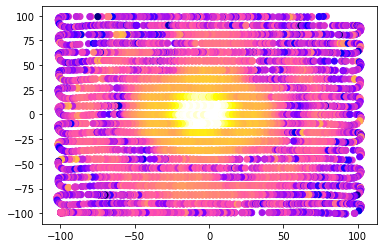

start of big ass loop is: 2023-06-09 14:09:21.623597
end of bigass loop is: 2023-06-09 14:09:27.726997   


/home/am3674/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:315: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)
<ipython-input-8-2d44efd33550>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],
<ipython-input-8-2d44efd33550>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(-1*sz,sz)
<ipython-input-8-2d44efd33550>:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-1*sz,sz)


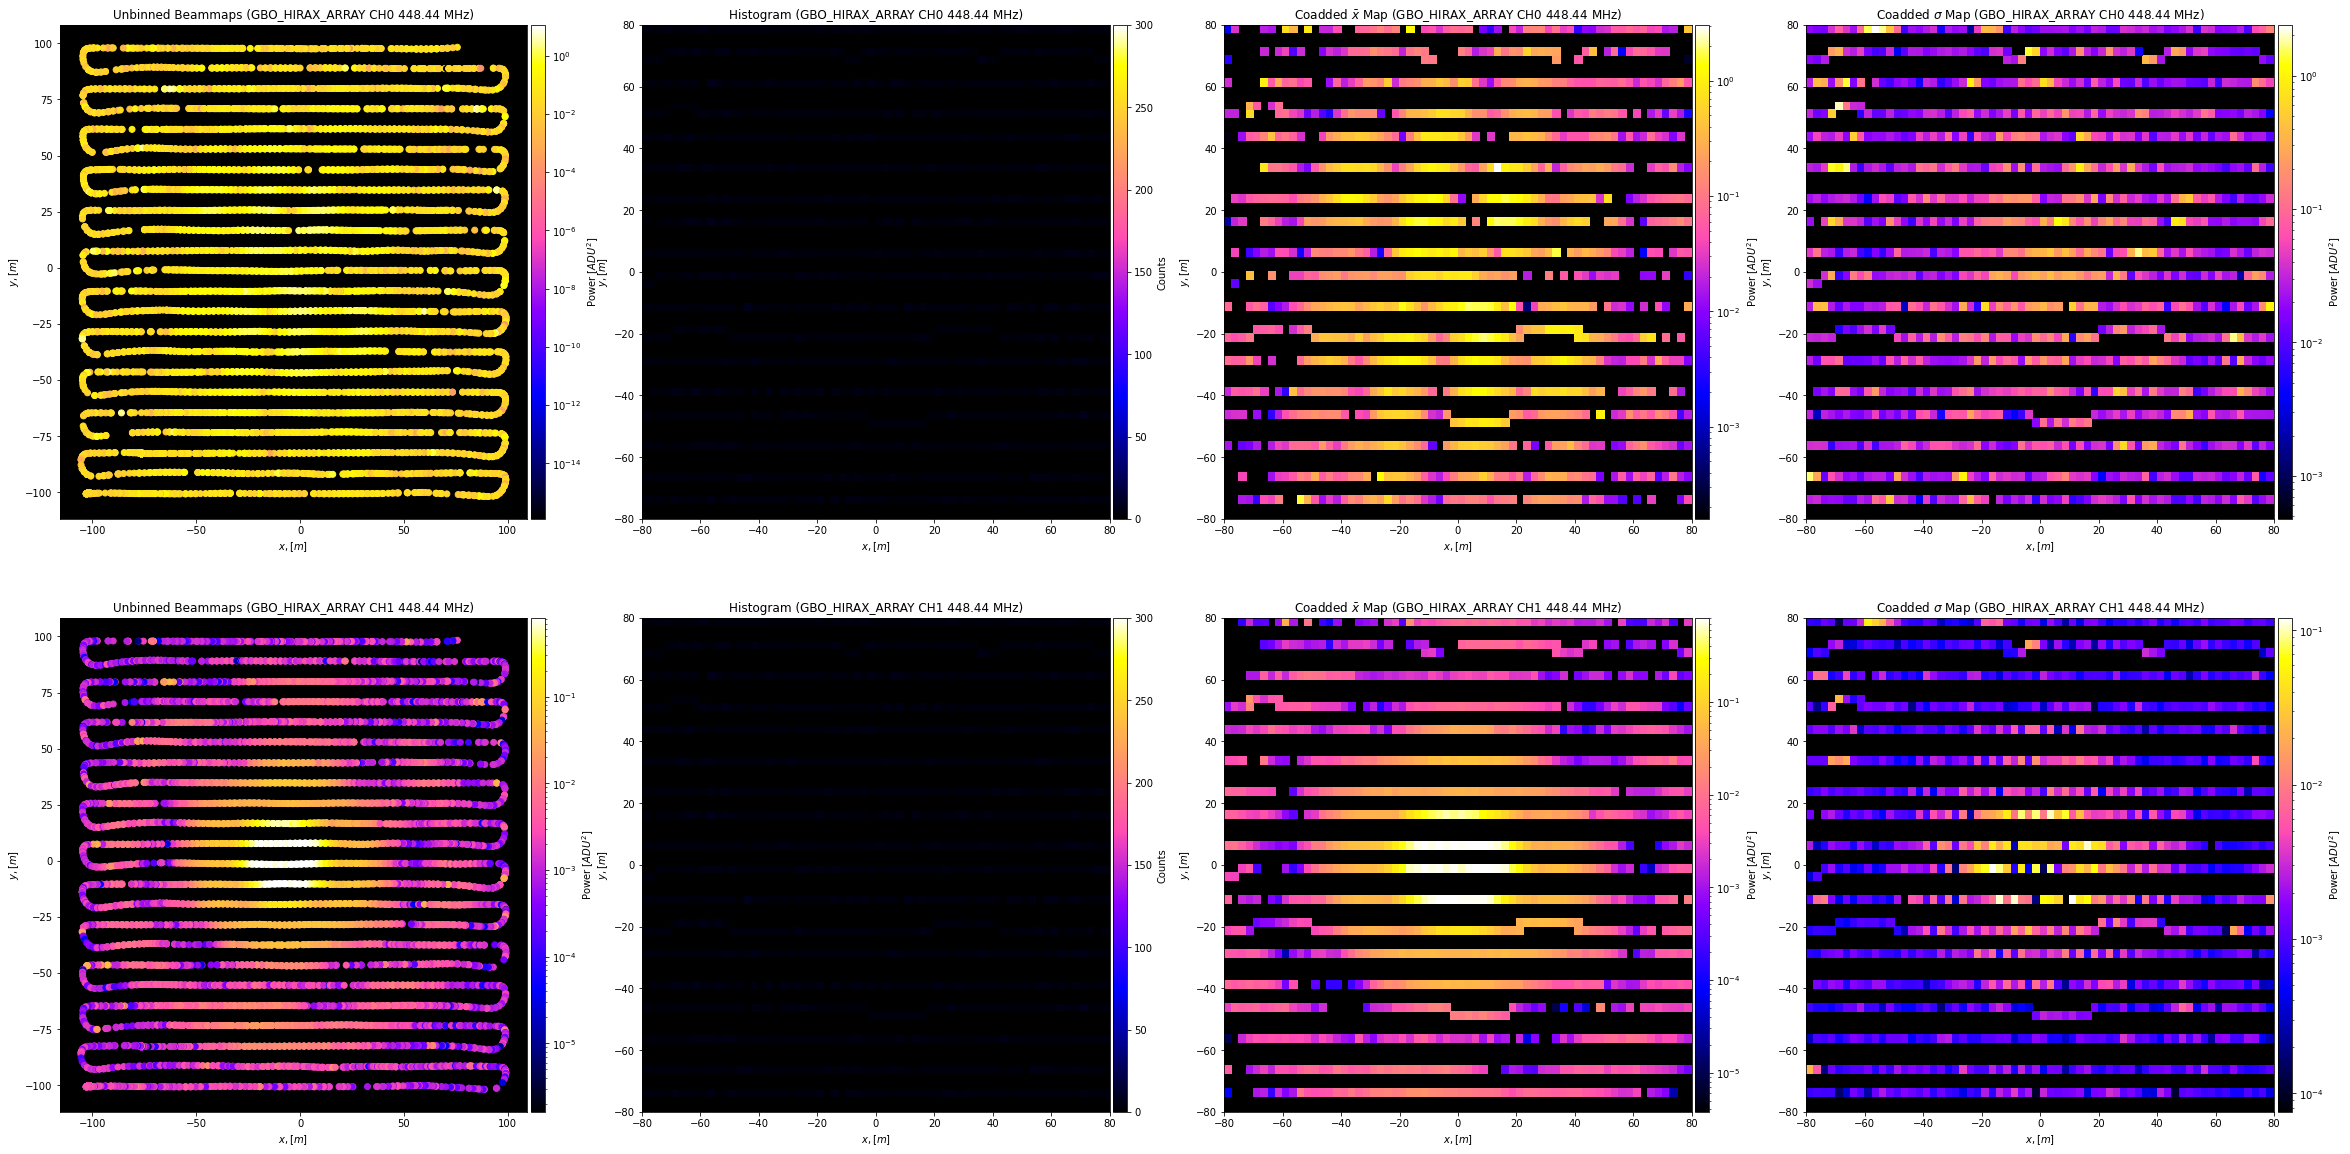

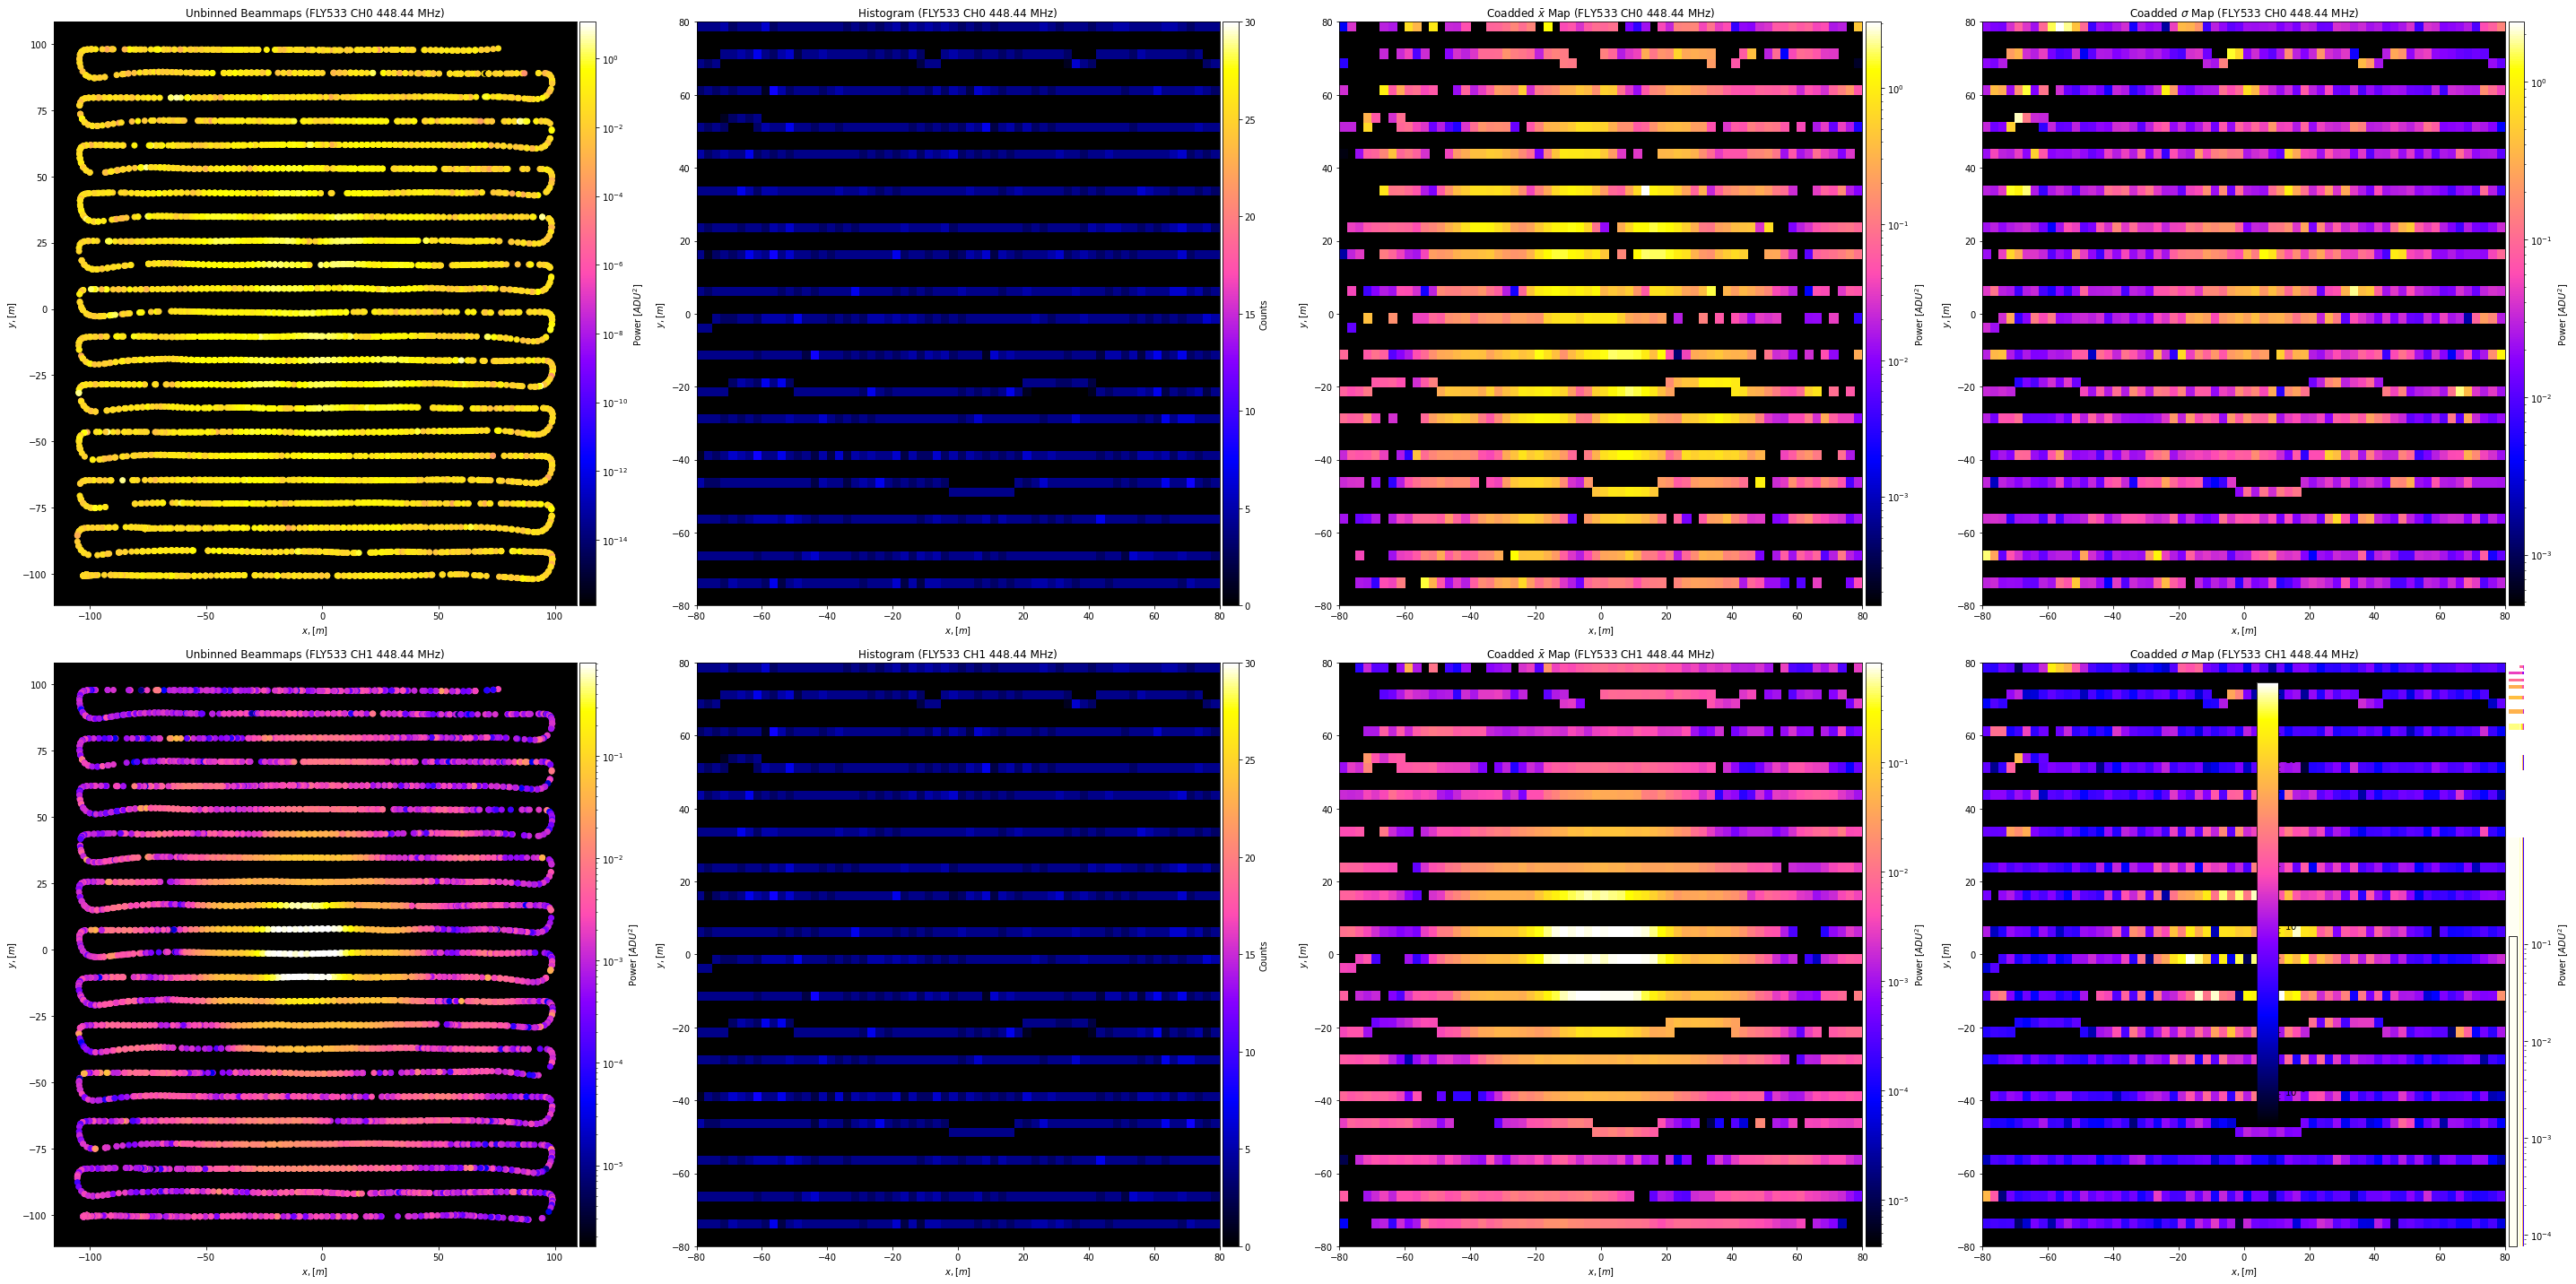

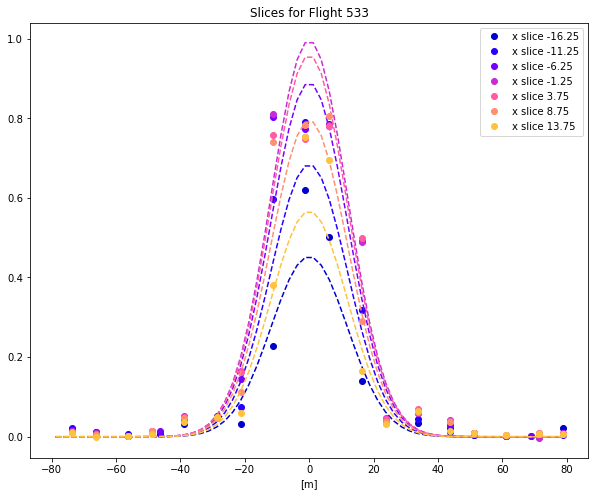

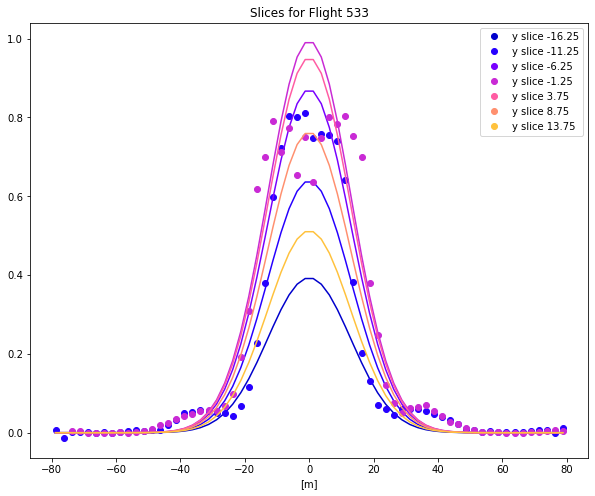

In [8]:
# Flight 1:: 

# Get info
pol, pols, cpols, attn, fi = get_flightinfo(fly1)
print(fly1,pol,pols,cpols, attn)
chind = pols[0]

concytest=[glob.glob(pckldir+'*'+fly1+'*')[0] for x in flights]
print(concytest[fi])

with open(glob.glob(pckldir+'*'+fly1+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on    

# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

beam1=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find-1,find+1,1],f_index=find)

plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],
               beam1.V_LC_operation[:,:,f_intern,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.colorbar()
plt.show()

fit = Gauss_2D_fromgrid(beam1,concattest1,find,chind)
#plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],10*np.log10(fit))
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    colx = get_slice(beam1,beam1.V_LC_mean[:,:,f_intern,chind,0],xx,'x')
    plt.plot(beam1.y_centers_grid[:,colx,0],beam1.V_LC_mean[colx,:,f_intern,chind,0].T,'o',color=cmap(norm(xx)),label='x slice '+str(beam1.x_centers_grid[0,colx,0]))
    plt.plot(beam1.y_centers_grid[:,colx,chind],fit[:,colx],color=cmap(norm(xx)),linestyle='--')#,label='x slice '+str(xx))
plt.title('Slices for Flight '+str(fly1))
plt.xlabel('[m]')
plt.legend()
fig = plt.gcf()
fig.savefig('Flight_'+str(fly1)+'_xslices.png')
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    coly = get_slice(beam1,beam1.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
    plt.plot(beam1.x_centers_grid[coly,:,0],beam1.V_LC_mean[:,coly,f_intern,chind,0].T,'o',color=cmap(norm(xx)),label='y slice '+str(beam1.y_centers_grid[coly,0,0]))
    plt.plot(beam1.x_centers_grid[coly,:,chind],fit[coly,:],color=cmap(norm(xx)))#,label='y slice '+str(xx))
plt.title('Slices for Flight '+str(fly1))
plt.xlabel('[m]')
plt.legend()
fig = plt.gcf()
fig.savefig('Flight_'+str(fly1)+'_yslices.png')
plt.show()


/home/am3674/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:488: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[chan_i,0].pcolormesh(self.x_centers_grid[:,:,chan_i],self.y_centers_grid[:,:,chan_i],V_LC_real[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
/home/am3674/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:493: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[chan_i,1].pcolormesh(x_interp,y_interp,self.beam_linear_interp[:

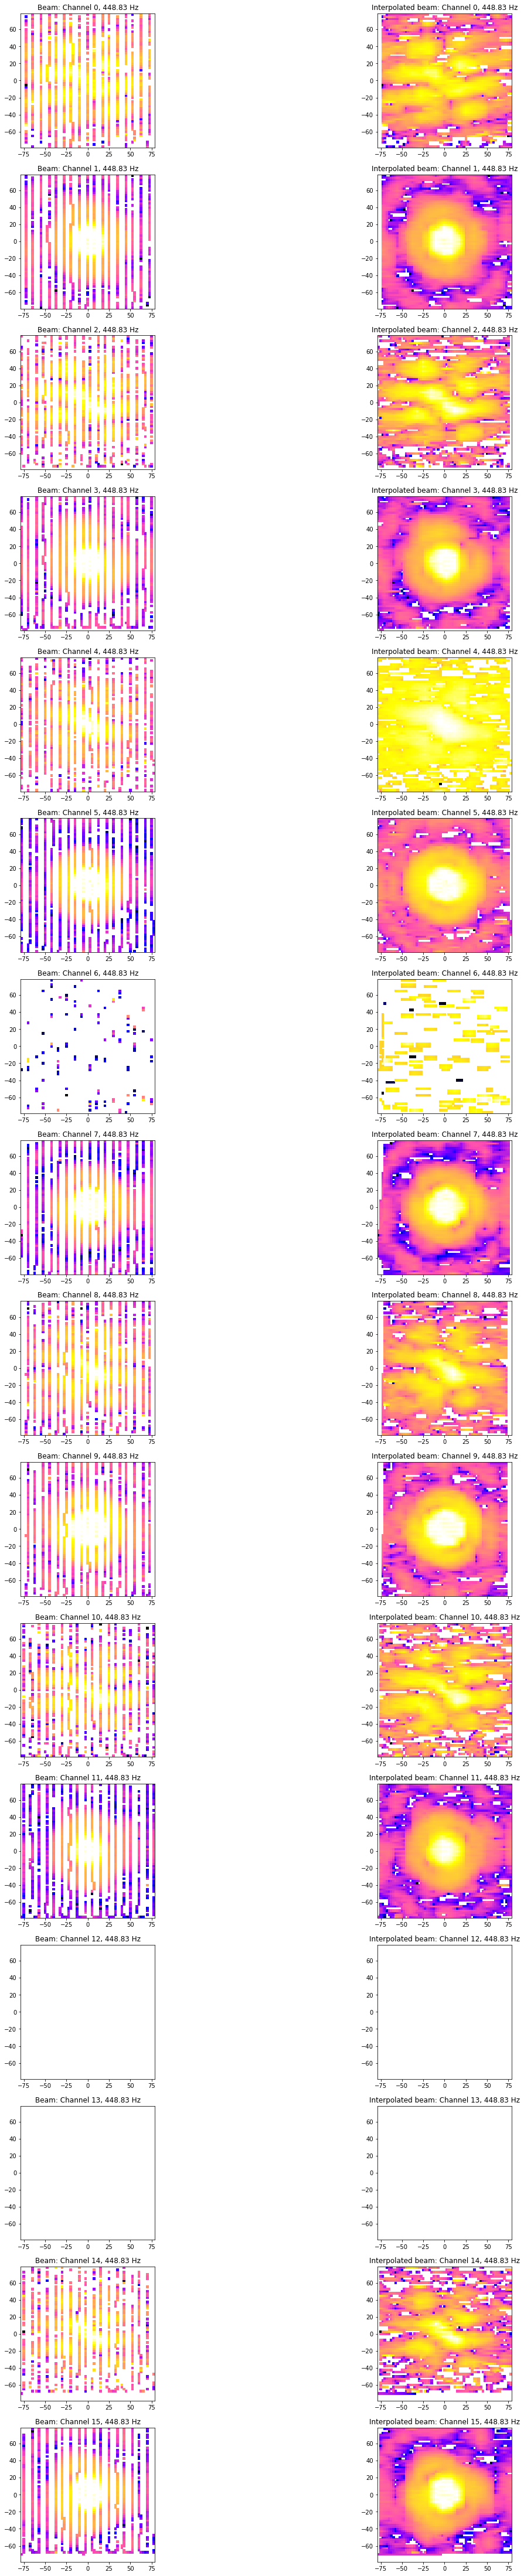

In [9]:
x_interp = beam1.x_centers_grid[0,:,0]
y_interp = beam1.y_centers_grid[:,0,0]
beam1.complex_interpolation(x_interp,y_interp,method='linear',outputs=True)

In [10]:
help(beam1.complex_interpolation)

Help on method complex_interpolation in module beamcals.beammap:

complex_interpolation(x_interp, y_interp, method='linear', variogram_model='spherical', outputs=False, Fargs=[0, 0]) method of beamcals.beammap.Beammap instance
    Interpolates a complex beam along a grid defined by 1-D vectors x-interp, y-interp.
    x_interp and y_interp: 1-D vectors that define a grid to which the beam is interpolated
    method: 'linear' for linear interpolation (faster) or 'krig' for Krig interpolation
    variogram_model: variogram model for krig interpolation. Options: 'linear', 'power', 'gaussian', 'spherical', 'exponential', 'hole-effect'
    outputs: if True, provides output plots for the indicated frequencies
    Fargs: provide a list [fmin,fmax] with the starting and ending frequency indices for which you want to see output plots



In [11]:
vars(beam1)

{'concat_list': array(['FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl'],
       dtype='<U54'),
 'gfit_list': array(['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'],
       dtype='<U51'),
 'ampcorr_list': [],
 'FLYNUM': '533',
 'copoldir': 'N',
 'name': 'GBO_HIRAX_ARRAY',
 'Data_Directory': '/hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/',
 'Gain_Directory': '/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T182904Z_yale_drone_yale_digitalgain/',
 'filenames': array(['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007',
        '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015',
        '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023',
        '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031',
        '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039',
        '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047',
        '0048', '0049', '0050', '0051', '0052', '0053'

In [12]:
Xargs = [-100,100,5]
Yargs = [-100,100,5]

xedges,yedges=(cedges(Xargs),cedges(Yargs))
xedgesgrid,yedgesgrid=np.meshgrid(xedges,yedges)
xcenters,ycenters=(cedges(Xargs)[:-1]+Xargs[2]/2.0,cedges(Yargs)[:-1]+Yargs[2]/2.0)
xcentersgrid,ycentersgrid=np.meshgrid(xcenters,ycenters)



In [14]:
print(xedges)
print(xcenters)
print(yedges)

[-100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.  -60.  -55.  -50.  -45.
  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.    0.    5.   10.   15.
   20.   25.   30.   35.   40.   45.   50.   55.   60.   65.   70.   75.
   80.   85.   90.   95.  100.]
[-97.5 -92.5 -87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 -47.5 -42.5
 -37.5 -32.5 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5   2.5   7.5  12.5  17.5
  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5  62.5  67.5  72.5  77.5
  82.5  87.5  92.5  97.5]
[-100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.  -60.  -55.  -50.  -45.
  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.    0.    5.   10.   15.
   20.   25.   30.   35.   40.   45.   50.   55.   60.   65.   70.   75.
   80.   85.   90.   95.  100.]


In [13]:
print(xedgesgrid)

[[-100.  -95.  -90. ...   90.   95.  100.]
 [-100.  -95.  -90. ...   90.   95.  100.]
 [-100.  -95.  -90. ...   90.   95.  100.]
 ...
 [-100.  -95.  -90. ...   90.   95.  100.]
 [-100.  -95.  -90. ...   90.   95.  100.]
 [-100.  -95.  -90. ...   90.   95.  100.]]


(64, 64, 2, 16)
(64, 64, 16)
(64, 64, 16)
16
(64, 64)
(1158,)
0


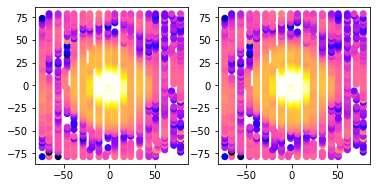

In [14]:
f_index = 1
chanind=chind

print(beam1.V_LC_operation.shape)

noNans = np.isfinite(beam1.V_LC_operation[:,:,f_index,chanind]) # all x, y, chosen frequency and channel
V_LC_selected = beam1.V_LC_operation[noNans,f_index,chanind]
x_noNan = beam1.x_centers_grid[noNans,chanind]
y_noNan = beam1.y_centers_grid[noNans,chanind]

print(beam1.x_centers_grid.shape)
print(beam1.y_centers_grid.shape)
print(beam1.n_channels)

print(noNans.shape)
print(x_noNan.shape)

fig,ax=plt.subplots(1,2)
ax[0].scatter(x_noNan,y_noNan,c=V_LC_selected,cmap=cm.gnuplot2,norm=LogNorm())
ax[0].set_aspect('equal')
print(np.sum(np.isnan(V_LC_selected)))

ax[1].scatter(beam1.x_centers_grid[:,:,chanind],beam1.y_centers_grid[:,:,chanind],c=beam1.V_LC_operation[:,:,f_index,chanind],cmap=cm.gnuplot2,norm=LogNorm())
ax[1].set_aspect('equal')

(1158,)
(1158,)
(1158,)
(64,)
(64,)
[[-78.75 -76.25 -73.75 ...  73.75  76.25  78.75]
 [-78.75 -76.25 -73.75 ...  73.75  76.25  78.75]
 [-78.75 -76.25 -73.75 ...  73.75  76.25  78.75]
 ...
 [-78.75 -76.25 -73.75 ...  73.75  76.25  78.75]
 [-78.75 -76.25 -73.75 ...  73.75  76.25  78.75]
 [-78.75 -76.25 -73.75 ...  73.75  76.25  78.75]]
[[-78.75 -78.75 -78.75 ... -78.75 -78.75 -78.75]
 [-76.25 -76.25 -76.25 ... -76.25 -76.25 -76.25]
 [-73.75 -73.75 -73.75 ... -73.75 -73.75 -73.75]
 ...
 [ 73.75  73.75  73.75 ...  73.75  73.75  73.75]
 [ 76.25  76.25  76.25 ...  76.25  76.25  76.25]
 [ 78.75  78.75  78.75 ...  78.75  78.75  78.75]]
(64, 64)


<ipython-input-15-9e2f89397a9c>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x_interp,y_interp,beam_linear_interp,cmap=cm.gnuplot2,norm=LogNorm())


Text(0.5, 1.0, 'Linearly interpolated beam map')

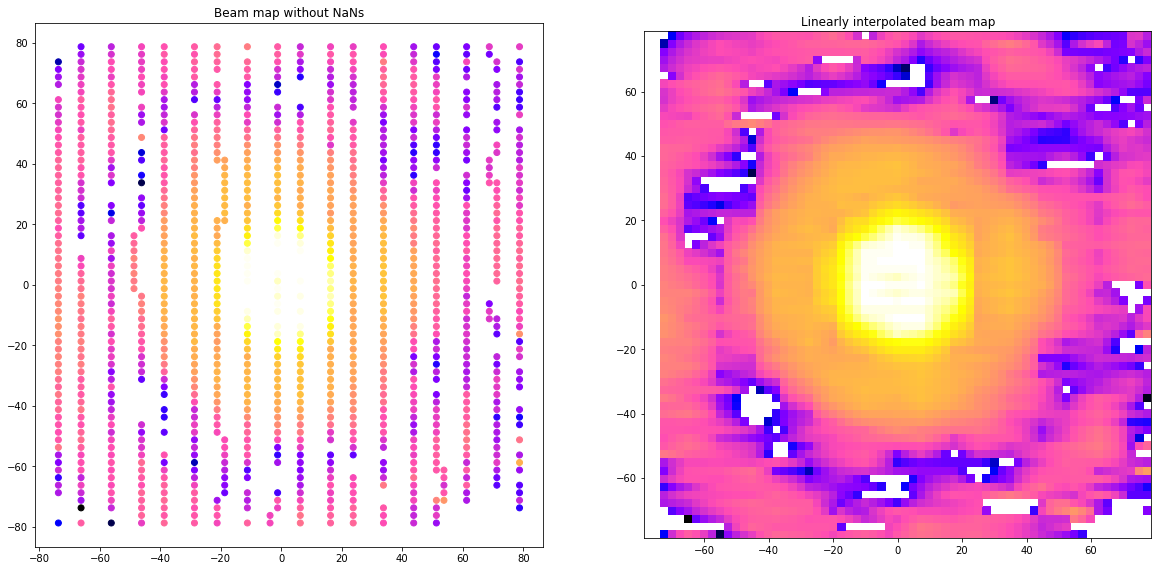

In [15]:
# running linear interpolation
# selected_indices = np.arange(0,64,2)
x_interp = beam1.x_centers_grid[0,:,chanind]
y_interp = beam1.y_centers_grid[:,0,chanind]
x_interp_grid, y_interp_grid = np.meshgrid(x_interp,y_interp)

print(x_noNan.shape)
print(y_noNan.shape)
print(V_LC_selected.shape)
print(x_interp.shape)
print(y_interp.shape)
print(x_interp_grid)
print(y_interp_grid)

beam_linear_interp = griddata((x_noNan,y_noNan), V_LC_selected, (x_interp_grid,y_interp_grid), method='linear')

print(beam_linear_interp.shape)

fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(x_noNan,y_noNan,c=V_LC_selected,cmap=cm.gnuplot2,norm=LogNorm())
ax[0].set_aspect('equal')
ax[0].set_title('Beam map without NaNs')
ax[1].pcolormesh(x_interp,y_interp,beam_linear_interp,cmap=cm.gnuplot2,norm=LogNorm())
ax[1].set_aspect('equal')
ax[1].set_title('Linearly interpolated beam map')


In [16]:
# testing out function so far
beam1.complex_interpolation(x_interp,y_interp,method='krig')

<ipython-input-17-5ce82d3270b7>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x_interp,y_interp,beam_linear_interp,cmap=cm.gnuplot2,norm=LogNorm())
<ipython-input-17-5ce82d3270b7>:15: RuntimeWarning: invalid value encountered in log10
  ax[2].pcolormesh(x_interp,y_interp,10*np.log10(beam1.Krig_Interp),cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)


Text(0.5, 1.0, 'Krig interpolated beam map, spherical variogram model')

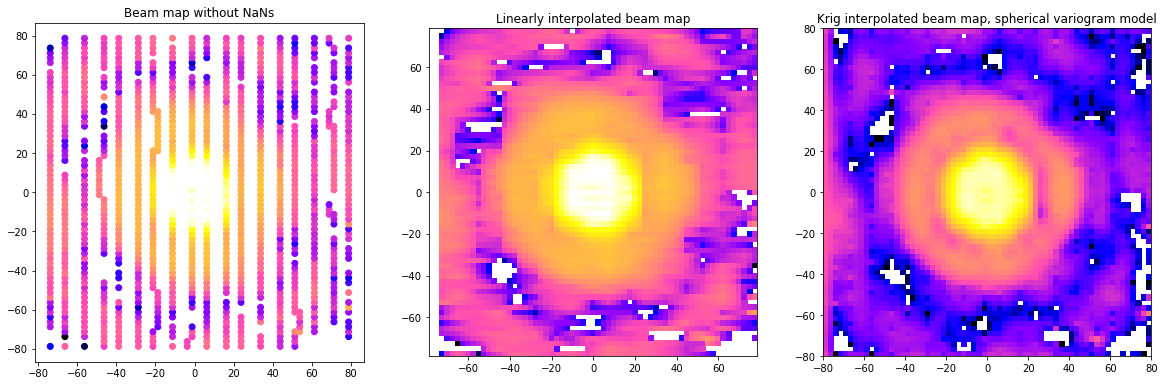

In [17]:
# running Krig interpolation

model='spherical'

beam_OK = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected,variogram_model=model)
beam1.Krig_Interp,ss = beam_OK.execute("grid",x_interp,y_interp)

fig,ax=plt.subplots(1,3,figsize=(20,10))
ax[0].scatter(x_noNan,y_noNan,c=V_LC_selected,cmap=cm.gnuplot2,norm=LogNorm())
ax[0].set_aspect('equal')
ax[0].set_title('Beam map without NaNs')
ax[1].pcolormesh(x_interp,y_interp,beam_linear_interp,cmap=cm.gnuplot2,norm=LogNorm())
ax[1].set_aspect('equal')
ax[1].set_title('Linearly interpolated beam map')
ax[2].pcolormesh(x_interp,y_interp,10*np.log10(beam1.Krig_Interp),cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)
ax[2].set_aspect('equal')
ax[2].set_title('Krig interpolated beam map, {:s} variogram model'.format(model))


In [18]:
f_index = 1
        chanind=0
        
#       for chanind in range(self.n_channels):
        # remove NaNs from data
        noNans = np.isfinite(self.V_LC_operation[:,:,f_index,chanind]) # all x, y, chosen frequency and channel
        V_LC_selected = self.V_LC_operation[noNans,f_index,chanind]
        x_noNan = self.x_centers_grid[noNans,chanind]
        y_noNan = self.y_centers_grid[noNans,chanind]
        
        print(x_noNan.shape)
        print(y_noNan.shape)
        
#         print((V_LC_selected))
        
#         plt.figure()
#         plt.pcolormesh(x_noNan[:,chanind],y_noNan[:,chanind],V_LC_selected)
#         print(np.sum(np.isnan(V_LC_selected)))


IndentationError: unexpected indent (<ipython-input-18-27db9e204e6c>, line 2)

In [ ]:
print(pols)

In [ ]:
method='linear'

print(beam1.n_channels)
print(beam1.faxis)
print(beam1.V_LC_operation.shape)

chanind=pols[0]
f_index=1

outputs=True

print(beam1.V_LC_operation.dtype)

variogram_model = 'spherical'

# if outputs==True:
#     fig,ax=(beam1.n_channels+1,2*len(beam1.faxis))

x_interp = beam1.x_centers_grid[0,:,pols[0]]
y_interp = beam1.y_centers_grid[:,0,pols[0]]
x_interp_grid, y_interp_grid = np.meshgrid(x_interp,y_interp)

if method == 'linear':
    beam1.beam_linear_interp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    beam1.beam_linear_interp_amp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    beam1.beam_linear_interp_phase = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    
if method == 'krig':
    beam1.Krig_Interp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    beam1.Krig_Interp_amp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    beam1.Krig_Interp_phase = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))

for f_index in range(len(beam1.faxis)):
        
    for chanind in range(beam1.n_channels):

        noNans = np.isfinite(beam1.V_LC_operation[:,:,f_index,chanind]) # all x, y, chosen frequency and channel
        V_LC_selected = beam1.V_LC_operation[noNans,f_index,chanind]
        
        if np.sum(noNans) != 0:
            
            x_noNan = beam1.x_centers_grid[noNans,chanind]
            y_noNan = beam1.y_centers_grid[noNans,chanind]
            
            # separating to real and imaginary
            V_LC_selected_real = V_LC_selected.real
            V_LC_selected_im = V_LC_selected.imag

            if method=='linear':

                # linear interpolation
                x_interp_grid, y_interp_grid = np.meshgrid(x_interp,y_interp)
                
                
                beam_linear_interp_real = griddata((x_noNan,y_noNan), V_LC_selected_real, (x_interp_grid,y_interp_grid), method='linear')
                beam_linear_interp_im = griddata((x_noNan,y_noNan), V_LC_selected_im, (x_interp_grid,y_interp_grid), method='linear')
                beam1.beam_linear_interp[:,:,f_index,chanind] = beam_linear_interp_real + 1j*beam_linear_interp_im
                beam1.beam_linear_interp_amp[:,:,f_index,chanind] = np.abs(beam1.beam_linear_interp[:,:,f_index,chanind])
                beam1.beam_linear_interp_phase[:,:,f_index,chanind] = np.angle(beam1.beam_linear_interp[:,:,f_index,chanind])
                
                fig,ax=plt.subplots(1,4,figsize=(20,10))
                ax[0].scatter(x_noNan,y_noNan,c=np.abs(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[0].set_aspect('equal')
                ax[0].set_title('Beam map amplitude without NaNs')
                ax[1].scatter(x_noNan,y_noNan,c=np.angle(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[1].set_aspect('equal')
                ax[1].set_title('Beam map phase without NaNs')
                ax[2].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp_amp[:,:,f_index,chanind],cmap=cm.gnuplot2,norm=LogNorm())
                ax[2].set_aspect('equal')
                ax[2].set_title('Linearly interpolated beam map amplitude')
                ax[3].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp_phase[:,:,f_index,chanind],cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)
                ax[3].set_aspect('equal')
                ax[3].set_title('Linearly interpolated beam map phase')

                
#                 if outputs==True:
#                     # plotting results
#                     ax[chanind,2*f_index].scatter(x_noNan,y_noNan,c=V_LC_selected,cmap=cm.gnuplot2,norm=LogNorm())
#                     ax[chanind,2*f_index].set_aspect('equal')
#                     ax[chanind,2*f_index].set_title('Beam map without NaNs for channel {}, {:.2f} Hz'.format(chanind,beam1.faxis[f_index]))
#                     ax[chanind,2*f_index+1].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp,cmap=cm.gnuplot2,norm=LogNorm())
#                     ax[chanind,2*f_index+1].set_aspect('equal')
#                     ax[chanind,2*f_index+1].set_title('Linearly interpolated beam map')

            if method == 'krig':

                # krig interpolation
                beam_OK_real = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_real,variogram_model=variogram_model)
                Krig_Interp_real,beam1.real_interp_variance = beam_OK_real.execute("grid",x_interp,y_interp)
                
                beam_OK_im = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_im,variogram_model=variogram_model)
                Krig_Interp_im,beam1.im_interp_variance = beam_OK_im.execute("grid",x_interp,y_interp)
                
                beam1.Krig_Interp[:,:,f_index,chanind] = Krig_Interp_real + 1j*Krig_Interp_im
                beam1.Krig_Interp_amp[:,:,f_index,chanind] = np.abs(beam1.Krig_Interp[:,:,f_index,chanind])
                beam1.Krig_Interp_phase[:,:,f_index,chanind] = np.angle(beam1.Krig_Interp[:,:,f_index,chanind])
                
                fig,ax=plt.subplots(1,4,figsize=(20,10))
                ax[0].scatter(x_noNan,y_noNan,c=np.abs(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[0].set_aspect('equal')
                ax[0].set_title('Beam map amplitude without NaNs')
                ax[1].scatter(x_noNan,y_noNan,c=np.angle(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[1].set_aspect('equal')
                ax[1].set_title('Beam map phase without NaNs')
                ax[2].pcolormesh(x_interp,y_interp,beam1.Krig_Interp_amp[:,:,f_index,chanind],cmap=cm.gnuplot2,norm=LogNorm())
                ax[2].set_aspect('equal')
                ax[2].set_title('Krig interpolated beam map amplitude, {:s} variogram model'.format(variogram_model))
                ax[3].pcolormesh(x_interp,y_interp,beam1.Krig_Interp_phase[:,:,f_index,chanind],cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)
                ax[3].set_aspect('equal')
                ax[3].set_title('Krig interpolated beam map phase, {:s} variogram model'.format(variogram_model))

#                 if outputs==True:
#                     # plotting results
#                     ax[chanind][2*f_index].scatter(x_noNan,y_noNan,c=V_LC_selected,cmap=cm.gnuplot2,norm=LogNorm())
#                     ax[chanind][2*f_index].set_aspect('equal')
#                     ax[chanind][2*f_index].set_title('Beam map without NaNs')
#                     ax[chanind][2*f_index+1].pcolormesh(x_interp,y_interp,10*np.log10(beam1.Krig_Interp),cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)
#                     ax[chanind][2*f_index+1].set_aspect('equal')
#                     ax[chanind][2*f_index+1].set_title('Krig interpolated beam map, {:s} variogram model'.format(variogram_model))


In [ ]:
variogram_model = 'spherical'
complex_beam = True
method='linear'

x_interp = beam1.x_centers_grid[0,:,pols[0]]
y_interp = beam1.y_centers_grid[:,0,pols[0]]
x_interp_grid, y_interp_grid = np.meshgrid(x_interp,y_interp)

if method == 'linear':
    beam1.beam_linear_interp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    
if method == 'krig':
    beam1.Krig_Interp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    
V_LC_real = beam1.V_LC_operation.real
V_LC_im = beam1.V_LC_operation.imag

if np.sum(V_LC_im)==0:
    complex_beam = False

if method == 'linear':
    beam1.beam_linear_interp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    
    if complex_beam:
        beam1.beam_linear_interp_amp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
        beam1.beam_linear_interp_phase = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    
if method == 'krig':
    beam1.Krig_Interp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    
    if complex_beam:
        beam1.Krig_Interp_amp = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
        beam1.Krig_Interp_phase = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))
    
for f_index in range(len(beam1.faxis)):
            
    for chanind in range(beam1.n_channels):

        noNans = np.isfinite(beam1.V_LC_operation[:,:,f_index,chanind]) # all x, y, chosen frequency and channel
        V_LC_selected = beam1.V_LC_operation[noNans,f_index,chanind]
        
        if np.sum(noNans) != 0:
            
            x_noNan = beam1.x_centers_grid[noNans,chanind]
            y_noNan = beam1.y_centers_grid[noNans,chanind]
            
            # separating to real and imaginary
            V_LC_selected_real = V_LC_selected.real
            
            if complex_beam:
                V_LC_selected_im = V_LC_selected.imag

            if method=='linear':

                # linear interpolation
                x_interp_grid, y_interp_grid = np.meshgrid(x_interp,y_interp)
                
                beam_linear_interp_real = griddata((x_noNan,y_noNan), V_LC_selected_real, (x_interp_grid,y_interp_grid), method='linear')
        
                if complex_beam:
                    beam_linear_interp_im = griddata((x_noNan,y_noNan), V_LC_selected_im, (x_interp_grid,y_interp_grid), method='linear')
                    beam1.beam_linear_interp[:,:,f_index,chanind] = beam_linear_interp_real + 1j*beam_linear_interp_im
                    beam1.beam_linear_interp_amp[:,:,f_index,chanind] = np.abs(beam1.beam_linear_interp[:,:,f_index,chanind])
                    beam1.beam_linear_interp_phase[:,:,f_index,chanind] = np.angle(beam1.beam_linear_interp[:,:,f_index,chanind])
                    
                else:
                    beam1.beam_linear_interp[:,:,f_index,chanind] = beam_linear_interp_real
                
                fig,ax=plt.subplots(1,4,figsize=(20,10))
                ax[0].scatter(x_noNan,y_noNan,c=np.abs(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[0].set_aspect('equal')
                ax[0].set_title('Beam map amplitude without NaNs')
                ax[1].scatter(x_noNan,y_noNan,c=np.angle(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[1].set_aspect('equal')
                ax[1].set_title('Beam map phase without NaNs')
                ax[2].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp_amp[:,:,f_index,chanind],cmap=cm.gnuplot2,norm=LogNorm())
                ax[2].set_aspect('equal')
                ax[2].set_title('Linearly interpolated beam map amplitude')
                ax[3].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp_phase[:,:,f_index,chanind],cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)
                ax[3].set_aspect('equal')
                ax[3].set_title('Linearly interpolated beam map phase')

                
#                 if outputs==True:
#                     # plotting results
#                     ax[chanind,2*f_index].scatter(x_noNan,y_noNan,c=V_LC_selected,cmap=cm.gnuplot2,norm=LogNorm())
#                     ax[chanind,2*f_index].set_aspect('equal')
#                     ax[chanind,2*f_index].set_title('Beam map without NaNs for channel {}, {:.2f} Hz'.format(chanind,beam1.faxis[f_index]))
#                     ax[chanind,2*f_index+1].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp,cmap=cm.gnuplot2,norm=LogNorm())
#                     ax[chanind,2*f_index+1].set_aspect('equal')
#                     ax[chanind,2*f_index+1].set_title('Linearly interpolated beam map')

            if method == 'krig':

                # krig interpolation
                beam_OK_real = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_real,variogram_model=variogram_model)
                Krig_Interp_real,beam1.real_interp_variance = beam_OK_real.execute("grid",x_interp,y_interp)
                
                if complex_beam:
                    beam_OK_im = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_im,variogram_model=variogram_model)
                    Krig_Interp_im,beam1.im_interp_variance = beam_OK_im.execute("grid",x_interp,y_interp)

                    beam1.Krig_Interp[:,:,f_index,chanind] = Krig_Interp_real + 1j*Krig_Interp_im
                    beam1.Krig_Interp_amp[:,:,f_index,chanind] = np.abs(beam1.Krig_Interp[:,:,f_index,chanind])
                    beam1.Krig_Interp_phase[:,:,f_index,chanind] = np.angle(beam1.Krig_Interp[:,:,f_index,chanind])
                    
                else:
                    beam1.Krig_Interp[:,:,f_index,chanind] = Krig_Interp_real
                    

                
                fig,ax=plt.subplots(1,4,figsize=(20,10))
                ax[0].scatter(x_noNan,y_noNan,c=np.abs(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[0].set_aspect('equal')
                ax[0].set_title('Beam map amplitude without NaNs, freq {}'.format(beam1.faxis[f_index]))
                ax[1].scatter(x_noNan,y_noNan,c=np.angle(V_LC_selected),cmap=cm.gnuplot2,norm=LogNorm())
                ax[1].set_aspect('equal')
                ax[1].set_title('Beam map phase without NaNs')
                ax[2].pcolormesh(x_interp,y_interp,10*np.log10(beam1.Krig_Interp[:,:,f_index,chanind]),cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)
                ax[2].set_aspect('equal')
                ax[2].set_title('Krig interpolated beam map amplitude, {:s} variogram model'.format(variogram_model))
                ax[3].pcolormesh(x_interp,y_interp,beam1.Krig_Interp_phase[:,:,f_index,chanind],cmap=cm.gnuplot2,shading='auto',vmin=-40,vmax=0)
                ax[3].set_aspect('equal')
                ax[3].set_title('Krig interpolated beam map phase, {:s} variogram model'.format(variogram_model))

In [ ]:
fmin = 0
fmax = 1

beam1.beam_linear_interp_amp=beam1.beam_linear_interp
beam1.beam_linear_interp_phase = np.zeros((len(x_interp),len(y_interp),len(beam1.faxis),beam1.n_channels))

complex_beam = False

print(beam1.beam_linear_interp_amp.shape)

if fmin==fmax:
    freq_indices=[fmin]
else:
    freq_indices=np.arange(fmin,fmax+1,1)

for f_index in freq_indices:

    if complex_beam:

        fig,ax=plt.subplots(beam1.n_channels,4,figsize=(15,5*beam1.n_channels))
        plt.tight_layout()
        for chan_i in range(beam1.n_channels):
            ax[chan_i,0].pcolormesh(beam1.x_centers_grid[:,:,chan_i],beam1.y_centers_grid[:,:,chan_i],np.abs(beam1.V_LC_operation[:,:,f_index,chan_i]),cmap=cm.gnuplot2,norm=LogNorm())
            ax[chan_i,0].set_title('Amplitude: Channel {}, freq {}'.format(chan_i,beam1.faxis[f_index]))
            ax[chan_i,1].pcolormesh(beam1.x_centers_grid[:,:,chan_i],beam1.y_centers_grid[:,:,chan_i],np.angle(beam1.V_LC_operation[:,:,f_index,chan_i]),cmap=cm.gnuplot2,norm=LogNorm())
            ax[chan_i,1].set_title('Phase: Channel {}, freq {}'.format(chan_i,beam1.faxis[f_index]))

            if method=='linear':
                ax[chan_i,2].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp_amp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
                ax[chan_i,3].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp_phase[:,:,f_index,chan_i],cmap=cm.gnuplot2)

            if method=='krig':
                ax[chan_i,2].pcolormesh(x_interp,y_interp,beam1.Krig_Interp_amp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
                ax[chan_i,3].pcolormesh(x_interp, y_interp,beam1.Krig_Interp_amp[:,:,f_index,chan_i],cmap=cm.gnuplot2)

            ax[chan_i,2].set_title('Interpolated amplitude: Channel {}, freq {}'.format(chan_i,beam1.faxis[f_index]))
            ax[chan_i,3].set_title('Interpolated phase: Channel {}, freq {}'.format(chan_i,beam1.faxis[f_index]))

            for i in range(4):
                ax[chan_i,i].set_aspect('equal')
    
    else:
        
        fig,ax=plt.subplots(beam1.n_channels,2,figsize=(20,5*beam1.n_channels))
        
        for chan_i in range(beam1.n_channels):
            
            ax[chan_i,0].pcolormesh(beam1.x_centers_grid[:,:,chan_i],beam1.y_centers_grid[:,:,chan_i],beam1.V_LC_operation[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
            ax[chan_i,0].set_title('Beam: Channel {}, freq {}'.format(chan_i,beam1.faxis[f_index]))
            ax[chan_i,1].set_title('Interpolated beam: Channel {}, freq {}'.format(chan_i,beam1.faxis[f_index]))
            
            if method=='linear':
                ax[chan_i,1].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
            
            if method=='krig':
                ax[chan_i,1].pcolormesh(x_interp,y_interp,beam1.beam_linear_interp[:,:,f_index,chan_i],cmap=cm.gnuplot2,norm=LogNorm())
                
            for i in range(2):
                ax[chan_i,i].set_aspect('equal')
            


In [ ]:
beam1.complex_interpolation(x_interp,y_interp,method='linear')

In [ ]:
beam1.beam_linear_interp[:,:,1,15]